<a href="https://colab.research.google.com/github/MuhamadRizky101/Data/blob/main/(versi_3)_Kegiatan_Modul_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Soal Praktikum Overfitting Handling #3 dan #4**

## Kegiatan 1 **(Individu)** 
70 poin

**Peraturan :**
* Tidak boleh ada error dalam kode program
* Kali ini anda dibebaskan untuk memilih satu dataset untuk kasus klasifikasi citra penyakit (pada manusia, hewan atau tumbuhan) menggunakan model CNN.
* Pastikan bahwa dataset tersebut termasuk dataset Imbalance.
* Dalam modul ini tidak diperbolehkan menggunakan teknik transfer learning dari pretrain model baik yang di bangun sendiri atau anda dapatkan dari sumber lain (tensorflow, keras, dan sebagainya)
* **Disarankan menggunakan Google Colab** dengan jenis runtime **GPU**
* Perhatikan langkah demi langkah yang diperintahkan dalam kegiatan ini

### **SOAL 1 :** 
---
* Lakukan resampling dataset agar dataset anda menjadi seimbang. Anda dibebaskan menggunakan teknik resampling apapun. Jelaskan tentang cara kerja metode resampling yang anda gunakan kepada asisten
* Melakukan proses EDA sesuai dengan kondisi data yang anda gunakan. Jelaskan kepada asisten terkait temuan kondisi data anda dan cara penanganannya 
* Melakukan ujicoba model dengan menerapkan materi pada modul-modul sebelumnya. (regularization, hiperparameter tuning, lr scheduler, dll) 
* Melakuakn augmentasi data menggunakan teknik image processing seperti (random noise, clahe, usuyama, blur, atau yang lainnya) dan ImageDataGenerator
- Membangun 2 model dengan ketentuan :
 1. Model pertama menggabungkan minimal **2 kombinasi pretrained architectures** yang berbeda sebagai ekstraksi fitur. Training pembobotan dilakukan pada layer eksperiment dengan menerapkan improvisasi training pada modul sebelumnya. Referensi pretrained arsitektur yang terdapat pada keras dapat anda lihat di laman berikut: https://www.tensorflow.org/api_docs/python/tf/keras/applications
 2. Model kedua menggunakan sebuah pretrained model bebas dengan improvisasi anda sendiri. Anda dapat menggunakan improvisasi pada modul sebelumnya dengan menggunakan dropout, regulizer, early stopping, callback training, grid search, dsb.
* Setiap model dilatih dengan jumlah epoch minimal 150 epoch dan output layer wajib menggunakan `softmax`.
* Membuat evaluasi model berupa plot nilai akurasi dan loss, metric akurasi, f-measure, recall, presisi, dan confusion matrix.
* Membuat kode untuk melakukkan prediksi pada 10 gambar acak yang belum pernah dipelajari oleh model sebelumnya kemudian menampilkannya dalam sebuah plot *(poin tambahan jika bisa menampilkan nilai confidence prediksi gambar dan lama waktu prediksi gambar)*
* Menyimpan semua model dalam format `tflite`

<img src = "https://i.imgur.com/4iskeo2.png" align="center">
<br/>
<h4>Gambar 1. Rancangan Model<h4/>

### Load Data

In [ ]:
# Tulis Program Anda Disini!
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, AveragePooling2D, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import EfficientNetB0
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.makedirs('/content/drive/MyDrive/Prak')

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Prak'

In [ ]:
%cd /content/drive/MyDrive/Prak

/content/drive/MyDrive/Prak


In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dinaardilia","key":"78757312cf856b19fb52c0aeb892c15a"}'}

In [ ]:
ls

kaggle.json


In [ ]:
!kaggle datasets download -d muhammadrizkyperdana/lungs-dataset

 99% 1.03G/1.04G [00:15<00:00, 95.8MB/s]
100% 1.04G/1.04G [00:15<00:00, 74.1MB/s]


In [ ]:
!unzip \*.zip &> /dev/null && rm *.zip

In [ ]:
pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio("Lungs Dataset", output="output", seed=1337, ratio=(.8, .19, .01), group_prefix=None)

Copying files: 7126 files [01:39, 71.56 files/s]


In [ ]:
%cd /content/drive/MyDrive/Prak/output/

/content/drive/MyDrive/Prak/output


In [ ]:
ls

test/  train/  val/


### Preprocessing

In [ ]:
generator = ImageDataGenerator(width_shift_range=0.2,
                              height_shift_range=0.2,
                              rescale=1./255,
                              shear_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')

In [ ]:
input_size = (100,100)
batch_size = 32

train = '/content/drive/MyDrive/Prak/output/train'
train_generator = generator.flow_from_directory(train,
                                                target_size = input_size,
                                                class_mode = 'categorical',
                                                batch_size = batch_size,
                                                shuffle = False)

val = '/content/drive/MyDrive/Prak/output/val'
val_generator = generator.flow_from_directory(val,
                                              target_size = input_size,
                                              class_mode = 'categorical',
                                              batch_size = batch_size,
                                              shuffle = False)

test = '/content/drive/MyDrive/Prak/output/test'
test_generator = generator.flow_from_directory(val,
                                              target_size = input_size,
                                              class_mode = 'categorical',
                                              batch_size = batch_size,
                                              shuffle = False)

Found 5699 images belonging to 4 classes.
Found 1353 images belonging to 4 classes.
Found 1353 images belonging to 4 classes.


### Model 1

In [ ]:
baseModel = VGG16(include_top=False, input_tensor=Input(shape=(100,100,3)))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
class FCHeadNet:
  def build(baseModel, classes, D):
    headModel = baseModel.output
    headModel = Dropout(0.5)(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(D, activation='relu')(headModel)
    headModel = Dense(classes, activation='softmax')(headModel)
    return headModel

In [ ]:
from tensorflow.keras.models import Model

headModel = FCHeadNet.build(baseModel, 4, 128)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
for layer in baseModel.layers:
  layer.trainable = False

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
#best_model_path = 'best_model.h5'
#checkpoint_callback = ModelCheckpoint(best_model_path,
#                                     monitor='val_acc',
#                                     save_best_only=True,
#                                     verbose=1)
reduce_callback = ReduceLROnPlateau(monitor='val_loss',mode="max", patience=10, factor=0.5, min_lr=0.001, verbose=1)
callbacks_list = [ reduce_callback]

In [ ]:
H = model.fit(train_generator,
              epochs = 150,
              validation_data = val_generator,
              #callbacks = [callbacks_list]
              )

Epoch 1/150
179/179 [==============================] - 2847s 16s/step - loss: 0.8165 - acc: 0.6231 - val_loss: 0.5187 - val_acc: 0.8315
Epoch 2/150
179/179 [==============================] - 67s 376ms/step - loss: 0.5913 - acc: 0.7443 - val_loss: 0.7056 - val_acc: 0.6615
Epoch 3/150
179/179 [==============================] - 68s 377ms/step - loss: 0.5494 - acc: 0.7682 - val_loss: 0.4459 - val_acc: 0.8248
Epoch 4/150
179/179 [==============================] - 66s 371ms/step - loss: 0.4803 - acc: 0.8103 - val_loss: 0.3311 - val_acc: 0.8766
Epoch 5/150
179/179 [==============================] - 66s 367ms/step - loss: 0.4410 - acc: 0.8165 - val_loss: 0.2910 - val_acc: 0.8973
Epoch 6/150
179/179 [==============================] - 65s 366ms/step - loss: 0.4502 - acc: 0.8201 - val_loss: 0.2585 - val_acc: 0.9084
Epoch 7/150
179/179 [==============================] - 67s 376ms/step - loss: 0.3542 - acc: 0.8575 - val_loss: 0.4846 - val_acc: 0.7761
Epoch 8/150
179/179 [===========================

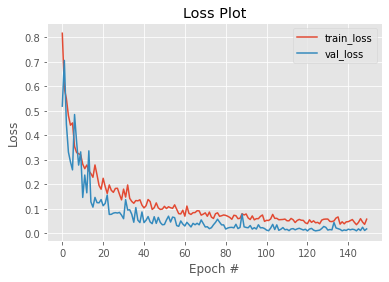

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 150), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 150), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

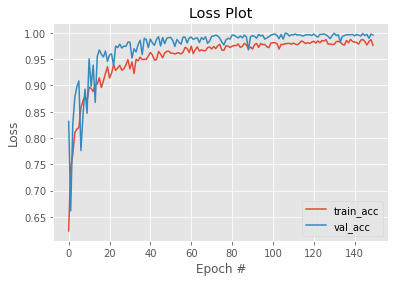

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 150), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 150), H.history["val_acc"], label="val_acc")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

Accuracy: 98.97%


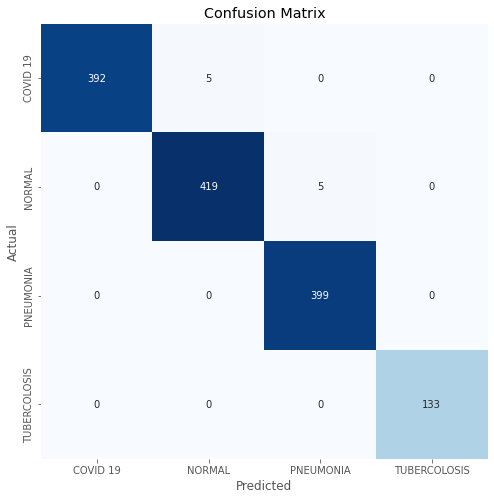

Classification Report:
----------------------
               precision    recall  f1-score   support

    COVID 19       1.00      0.99      0.99       397
      NORMAL       0.99      0.99      0.99       424
   PNEUMONIA       0.99      1.00      0.99       399
TUBERCOLOSIS       1.00      1.00      1.00       133

    accuracy                           0.99      1353
   macro avg       0.99      0.99      0.99      1353
weighted avg       0.99      0.99      0.99      1353



In [ ]:
import seaborn as sns
target_name = ['COVID 19', 'NORMAL', 'PNEUMONIA', 'TUBERCOLOSIS']
acc = model.evaluate(test_generator, verbose=0)
print("Accuracy: {:.2f}%".format(acc[1] * 100))

predictions = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(test_generator.labels, predictions, labels=[0, 1, 2,3])
clr = classification_report(test_generator.labels, predictions, labels=[0, 1, 2,3], target_names=target_name)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=target_name)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=target_name)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [ ]:
%cd /content/drive/MyDrive/Prak

/content/drive/MyDrive/Prak


In [ ]:
model.save('VGG.tflite')

INFO:tensorflow:Assets written to: VGG.tflite/assets


In [ ]:
model.save('VGG.h5')

In [ ]:
model.save('VGG.json')

INFO:tensorflow:Assets written to: VGG.json/assets


### Model 2

In [ ]:
#Model 2
model2 = Sequential()
model2.add(InputLayer(input_shape= [100,100,3]))
model2.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=2, padding='same'))
model2.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=2, padding='same'))
model2.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=2, padding='same'))
model2.add(Dropout(0.25))
model2.add(Flatten())

#fully connected layer
model2.add(Dense(128, activation='relu'))
model2.add(Dense(4, activation= 'softmax'))

#summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 50, 50, 64)       256       
 hNormalization)                                                 
                                                        

In [ ]:
# Compile model
model2.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [ ]:
# Callback untuk menyimpan akurasi yang terbaik dan menaikkan nilai akurasi walaupun tidak signifikan

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
best_model_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(best_model_path,
                                     monitor='val_acc',
                                     save_best_only=True,
                                     verbose=1)
reduce_callback = ReduceLROnPlateau(monitor='val_loss',mode="min", patience=10, factor=0.2, min_lr=0.001, verbose=1)
callbacks_list = [reduce_callback]

In [ ]:
Hi = model2.fit(train_generator,
              epochs = 150,
              validation_data = val_generator,
              callbacks = [callbacks_list]
              )

Epoch 1/150
179/179 [==============================] - 877s 5s/step - loss: 2.0998 - acc: 0.4248 - val_loss: 27.3855 - val_acc: 0.2203 - lr: 0.0010
Epoch 2/150
179/179 [==============================] - 67s 376ms/step - loss: 1.0109 - acc: 0.4790 - val_loss: 1.5621 - val_acc: 0.4161 - lr: 0.0010
Epoch 3/150
179/179 [==============================] - 67s 372ms/step - loss: 0.9773 - acc: 0.5180 - val_loss: 0.9092 - val_acc: 0.5551 - lr: 0.0010
Epoch 4/150
179/179 [==============================] - 66s 371ms/step - loss: 0.9153 - acc: 0.6205 - val_loss: 1.2564 - val_acc: 0.5920 - lr: 0.0010
Epoch 5/150
179/179 [==============================] - 66s 369ms/step - loss: 0.6588 - acc: 0.7487 - val_loss: 0.6669 - val_acc: 0.7561 - lr: 0.0010
Epoch 6/150
179/179 [==============================] - 66s 371ms/step - loss: 0.5314 - acc: 0.7926 - val_loss: 1.8956 - val_acc: 0.6460 - lr: 0.0010
Epoch 7/150
179/179 [==============================] - 67s 374ms/step - loss: 0.4278 - acc: 0.8373 - val_lo

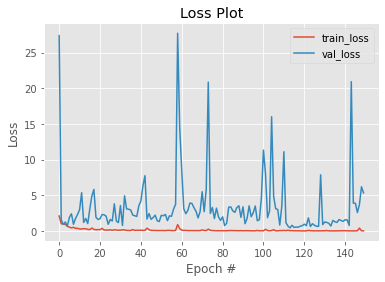

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 150), Hi.history["loss"], label="train_loss")
plt.plot(np.arange(0, 150), Hi.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

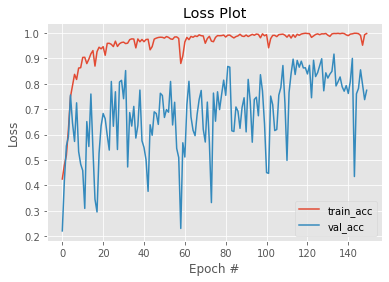

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 150), Hi.history["acc"], label="train_acc")
plt.plot(np.arange(0, 150), Hi.history["val_acc"], label="val_acc")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

Accuracy: 76.64%


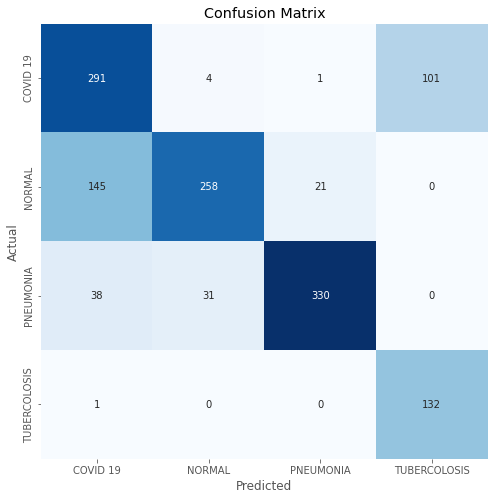

Classification Report:
----------------------
               precision    recall  f1-score   support

    COVID 19       0.61      0.73      0.67       397
      NORMAL       0.88      0.61      0.72       424
   PNEUMONIA       0.94      0.83      0.88       399
TUBERCOLOSIS       0.57      0.99      0.72       133

    accuracy                           0.75      1353
   macro avg       0.75      0.79      0.75      1353
weighted avg       0.79      0.75      0.75      1353



In [ ]:
import seaborn as sns
target_name = ['COVID 19', 'NORMAL', 'PNEUMONIA', 'TUBERCOLOSIS']
acc = model2.evaluate(test_generator, verbose=0)
print("Accuracy: {:.2f}%".format(acc[1] * 100))

predictions = np.argmax(model2.predict(test_generator), axis=1)

cm = confusion_matrix(test_generator.labels, predictions, labels=[0, 1, 2,3])
clr = classification_report(test_generator.labels, predictions, labels=[0, 1, 2,3], target_names=target_name)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=target_name)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=target_name)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [ ]:
%cd /content/drive/MyDrive/Prak

/content/drive/MyDrive/Prak


In [ ]:
model2.save('EfficientNetB0.tflite')
model2.save('EfficientNetB0.h5')
model2.save('EfficientNetB0.json')

INFO:tensorflow:Assets written to: EfficientNetB0.tflite/assets
INFO:tensorflow:Assets written to: EfficientNetB0.json/assets


### Prediksi

**Contoh prediksi 10 gambar baru**

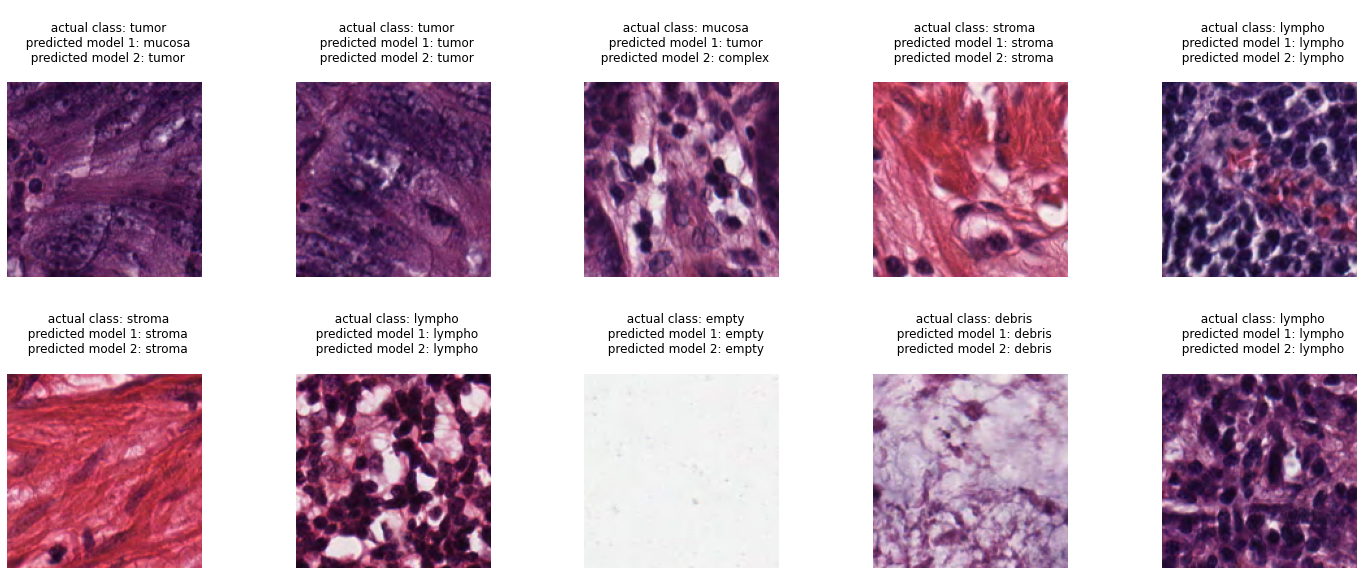

In [ ]:
from tensorflow.keras.models import load_model

MODEL_PATH = '/content/drive/MyDrive/Prak/VGG.h5'
model = load_model(MODEL_PATH,compile=False)

MODEL_PATH_2 = '/content/drive/MyDrive/Prak/Model.h5'
model2 = load_model(MODEL_PATH_2,compile=False)

In [ ]:
os.listdir('/content/drive/MyDrive/Prak/output/test/')

['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCOLOSIS']

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mping

file_test_COVID19 = os.path.join('/content/drive/MyDrive/Prak/output/test/COVID19')
file_test_NORMAL = os.path.join('/content/drive/MyDrive/Prak/output/test/NORMAL')
file_test_PNEUMONIA = os.path.join('/content/drive/MyDrive/Prak/output/test/PNEUMONIA')
file_test_TUBERCOLOSIS = os.path.join('/content/drive/MyDrive/Prak/output/test/TUBERCOLOSIS')

COVID19_image = os.listdir(file_test_COVID19)
NORMAL_image = os.listdir(file_test_NORMAL)
PNEUMONIA_image = os.listdir(file_test_PNEUMONIA)
TUBERCOLOSIS_image = os.listdir(file_test_TUBERCOLOSIS)

fname1 = [os.path.join(file_test_COVID19,fname)
        for fname in COVID19_image[0:5]]

fname2 = [os.path.join(file_test_NORMAL,fname)
        for fname in NORMAL_image[0:5]]

fname3 = [os.path.join(file_test_PNEUMONIA,fname)
        for fname in PNEUMONIA_image[0:5]]

fname4 = [os.path.join(file_test_TUBERCOLOSIS,fname)
        for fname in TUBERCOLOSIS_image[10:16]]

In [ ]:
from PIL import Image
import time
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

labels = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCOLOSIS']
labels2 = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCOLOSIS']
isian = [fname1, fname2, fname3, fname4]
input_size = (100, 100)

title = []
prediksi1 = []
prediksi2 = []
waktu = []
akurasi1 = []
akurasi2 = []

for x in list(range(len(labels))):
  for gambar in isian[x]:
    title.append(labels2[x])
    im = Image.open(gambar)
    X = preprocess(im, input_size)
    X = reshape([X])
    start = time.time()
    Y1 = model.predict(X)
    Y2 = model2.predict(X)
    end = time.time()
    times = end-start
    prediksi1.append(labels[np.argmax(Y1)])
    prediksi2.append(labels[np.argmax(Y2)])
    waktu.append(times)
    akurasi1.append(np.max(Y1))
    akurasi2.append(np.max(Y2))

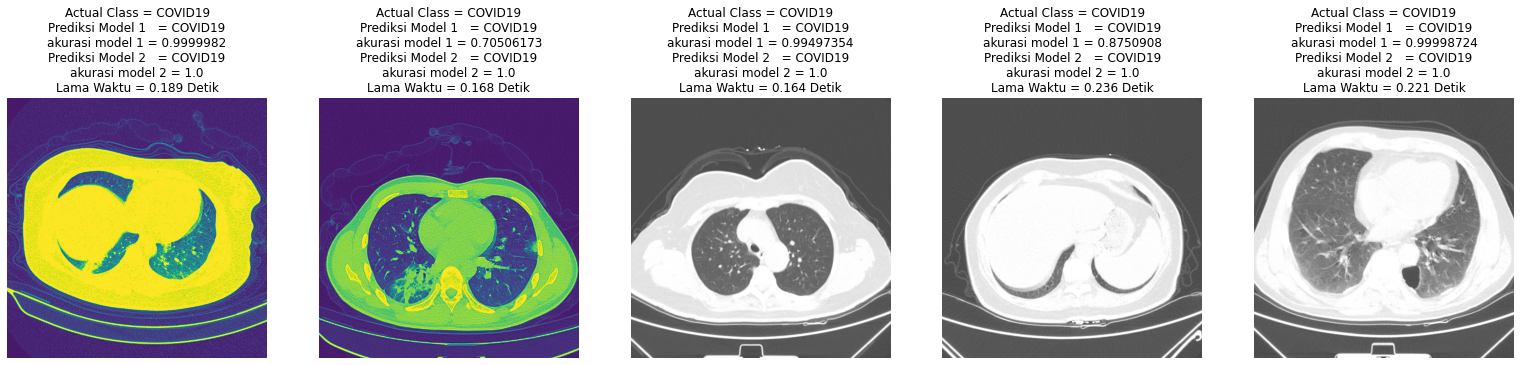

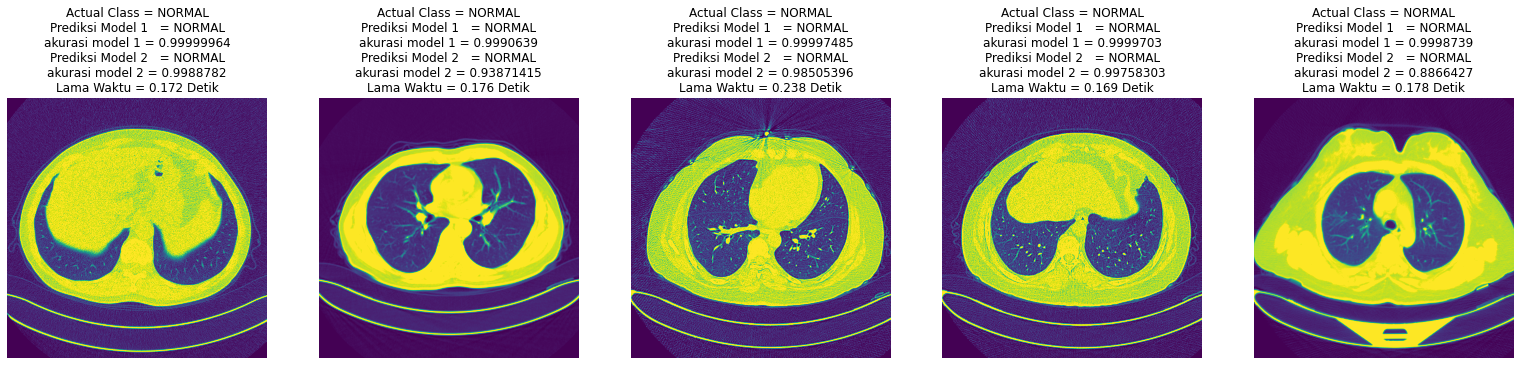

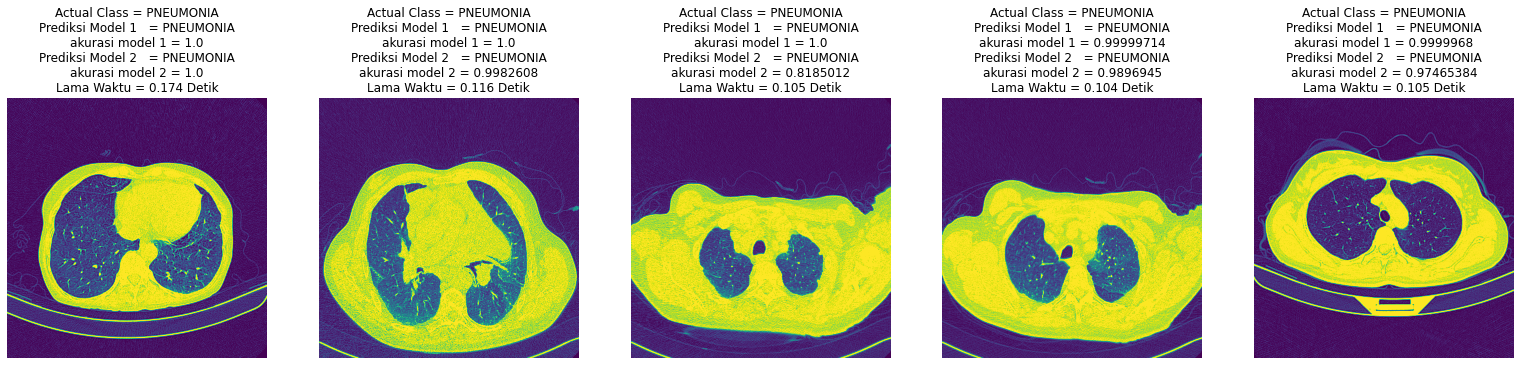

<Figure size 1944x1440 with 0 Axes>

In [ ]:
xz = 0

ncolu = 3
nrow = 5
fig = plt.gcf()
fig.set_size_inches(ncolu*9,nrow*4)
for i,fname in enumerate(fname1):
    sp = plt.subplot(3,5,i+1)
    sp.axis('off')
    img = mping.imread(fname)
    judul = 'Actual Class = COVID19' + '\nPrediksi Model 1   = ' + prediksi1[xz] + '\nakurasi model 1 = '+ str(akurasi1[xz]) +'\nPrediksi Model 2   = ' + prediksi2[xz] + '\nakurasi model 2 = '+ str(akurasi2[xz]) +'\nLama Waktu = ' + '{:.3f}'.format(waktu[xz]) + ' Detik'
    xz = xz+1
    plt.title(judul)
    plt.imshow(img)
plt.show()

ncolu = 3
nrow = 5
fig = plt.gcf()
fig.set_size_inches(ncolu*9,nrow*4)
for i,fname in enumerate(fname2):
    sp = plt.subplot(3,5,i+1)
    sp.axis('off')
    img = mping.imread(fname)
    judul = 'Actual Class = NORMAL' + '\nPrediksi Model 1   = ' + prediksi1[xz] + '\nakurasi model 1 = '+ str(akurasi1[xz]) +'\nPrediksi Model 2   = ' + prediksi2[xz] + '\nakurasi model 2 = '+ str(akurasi2[xz]) +'\nLama Waktu = ' + '{:.3f}'.format(waktu[xz]) + ' Detik'
    xz = xz+1
    plt.title(judul)
    plt.imshow(img)
plt.show()

ncolu = 3
nrow = 5
fig = plt.gcf()
fig.set_size_inches(ncolu*9,nrow*4)
for i,fname in enumerate(fname3):
    sp = plt.subplot(3,5,i+1)
    sp.axis('off')
    img = mping.imread(fname)
    judul = 'Actual Class = PNEUMONIA' + '\nPrediksi Model 1   = ' + prediksi1[xz] + '\nakurasi model 1 = '+ str(akurasi1[xz]) +'\nPrediksi Model 2   = ' + prediksi2[xz] + '\nakurasi model 2 = '+ str(akurasi2[xz]) + '\nLama Waktu = ' + '{:.3f}'.format(waktu[xz]) + ' Detik'
    xz = xz+1
    plt.title(judul)
    plt.imshow(img)
plt.show()

ncolu = 3
nrow = 5
fig = plt.gcf()
fig.set_size_inches(ncolu*9,nrow*4)
for i,fname in enumerate(fname4):
    sp = plt.subplot(3,5,i+1)
    sp.axis('off')
    img = mping.imread(fname)
    judul = 'Actual Class = TUBERCOLOSIS' + '\nPrediksi Model 1   = ' + prediksi1[xz] + '\nakurasi model 1 = '+ str(akurasi1[xz]) +'\nPrediksi Model 2   = ' + prediksi2[xz] + '\nakurasi model 2 = '+ str(akurasi2[xz]) +'\nLama Waktu = ' + '{:.3f}'.format(waktu[xz]) + ' Detik'
    xz = xz+1
    plt.title(judul)
    plt.imshow(img)
plt.show()

## Kegiatan 2 **(berkelompok)**
30 poin

**Ketentuan Wajib**
* Tulis dokumentasi tugas kelompok anda dalam file README.md
* Cek daftar dataset seluruh praktikan [disini](https://docs.google.com/spreadsheets/d/1qyu5AVDhPhegpRTbNaDoq5qXX4_CX09Q7tYyD-fkF_c/edit?usp=sharing)
* Seluruh data dan progress pengerjaan tugas kelompok harus berada dalam github repository sebelum praktikum dimulai
* Tidak diperbolehkan berganti anggota kelompok selama satu semester ini
* Tidak diperbolehkan berganti repository selama mengerjakan tugas kelompok ini
* **Tidak diperbolehkan berganti dataset atau jurnal rujukan**
* Pastikan anda menggunakan akun github pribadi untuk melakukan commit dan push

**Penilaian**
* Keaktifan dalam tim
* Kontribusi dalam proyek dan tim
* Penerapan prinsip kerja Agile (sprint backlog dan report terdokumentasikan dengan baik)
* Progress pengerjaan tugas kelompok
* Problem solving masing - masing anggota terhadap kendala yang dialami
* Pemahaman masing - masing anggota tim terhadap tugas yang dikerjakan
* Pendokumentasian proyek "clear and clean documentation"

**Materi pendukung**
* [Project documentation](https://realpython.com/documenting-python-code)
* [Github readme](https://docs.github.com/en/github/writing-on-github/getting-started-with-writing-and-formatting-on-github/basic-writing-and-formatting-syntax)
* [Sprint backlog](https://www.lucidchart.com/blog/how-to-develop-a-product-backlog-in-agile)

**Tugas**

Melanjutkan tugas kelompok di modul 1 sampai 3 sekarang kerjakan beberapa poin berikut untuk didemokan kepada asisten masing-masing.

*   Melakukan proses preprocessing dataset dengan ketentuan:
 * augmentasi data menggunakan ImageDataGenerator dan salah satu augmentasi opsional lain seperti (random noise, clahe, usuyama, blur, atau yang lainnya)
 * balancing dataset menggunakan teknik oversampling / downsampling
 * splitting dataset menjadi (75% train, 14% validation, 1% test)
*   Melakukan training beberapa skema model menggunakan pretrained model **(minimal 2 model)** dengan 100 epoch per model
* Menyimpan model yang telah di training kedalam file `.tflite`  [Lihat disini](https://www.tensorflow.org/lite/convert)
*  Mencatat hasil perkembangan tugas kelompok dalam file `sprint_project.xlsx` tandai masing-masing task dengan status **Done** *untuk task yang telah selesai dikerjakan*, **On Going** *untuk task yang dalam proses pengerjaan*, **Waiting** *untuk task yang belum atau akan dikerjakan*
* Pastikan anda menulis tanggal mulai dan tanggal selesai masing-masing task dengan benar
* Pastikan anda menulis penanggung jawab masing-masing task (Penanggung jawab bertugas menyelesaikan dan menuntaskan masing-masing task yang diberikan)
* `commit` dan `push` seluruh perkerjaan yang anda lakukan kedalam branch pribadi dalam repository tugas kelompok yang telah anda buat sebelumnya.
* Presentasikan kepada asisten tentang apa yang anda lakukakan selama mengerjakan tugas kelompok ini. Ceritakan tentang tugas masing-masing anggota,  kendala dalam mengerjakan tugas sampai solusi yang anda lakukan saat mengerjakan tugas kelompok ini.

